In [3]:
import torch
import timm
import scipy

from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10,CIFAR100,Food101
from torchvision.transforms import Compose, ToTensor, Normalize
import os
import random
from itertools import permutations

import torch
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.manifold import TSNE

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects


In [116]:
# Define our own plot function
def scatter(x, labels, root='plot', subtitle=None, idx2name=None):
    
    num_classes = len(idx2name) # Calculate the number of classes
    palette = np.array(sns.color_palette("hls", num_classes)) # Choosing color

    ## Create a seaborn scatter plot ##
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[labels.astype(np.int32)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
    ## ---------------------------- ##
    
        
    txts = []
    for i in range(num_classes):
        # Position of each label.
        xtext, ytext = np.median(x[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, idx2name[i], fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)        
        
    ## ---------------------------- ##    
        
    if subtitle != None:
        plt.suptitle(subtitle)
        
    if not os.path.exists(root):
        os.makedirs(root)
    print(os.path.join(root, str(subtitle)))
    plt.savefig(os.path.join(root, str(subtitle)))

In [48]:
tsne = TSNE(random_state=0)

In [49]:
train_loader = DataLoader(CIFAR10('./CIFAR10/', train=True, download=True,
                                transform=Compose([ToTensor(),Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
                               ),batch_size=128, shuffle=True,num_workers=0)
test_loader = DataLoader(CIFAR10('./CIFAR10/', train=False, download=True,
                                transform=Compose([ToTensor(),Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
                               ),batch_size=128, shuffle=False,num_workers=0,)

Files already downloaded and verified
Files already downloaded and verified


In [51]:
x_test, y_test = next(iter(test_loader))
x_test = x_test.flatten(1).detach().numpy()
y_test = y_test.detach().numpy()

In [52]:
x_train, y_train = next(iter(train_loader))
x_train = x_train.flatten(1).detach().numpy()
y_train = y_train.detach().numpy()

In [112]:
train_tsne_embeds = tsne.fit_transform(x_train)
test_tsne_embeds = tsne.fit_transform(x_test)

In [113]:
idx2name=train_loader.dataset.classes

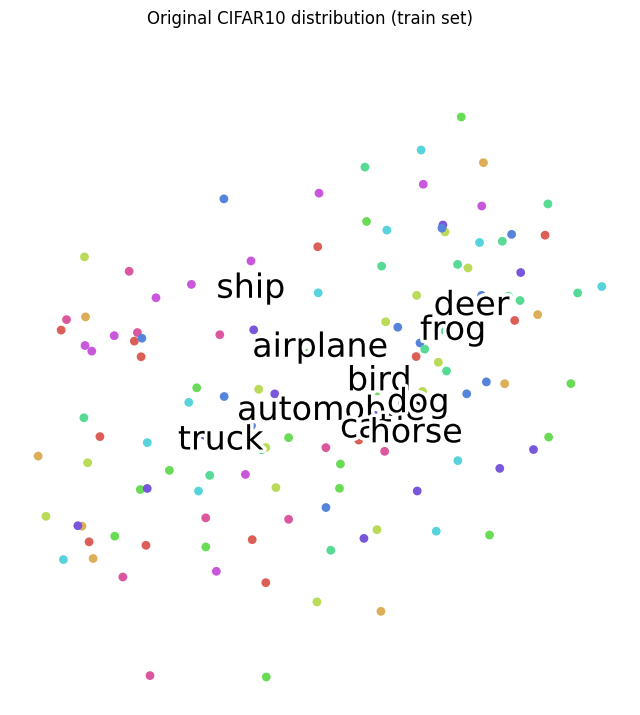

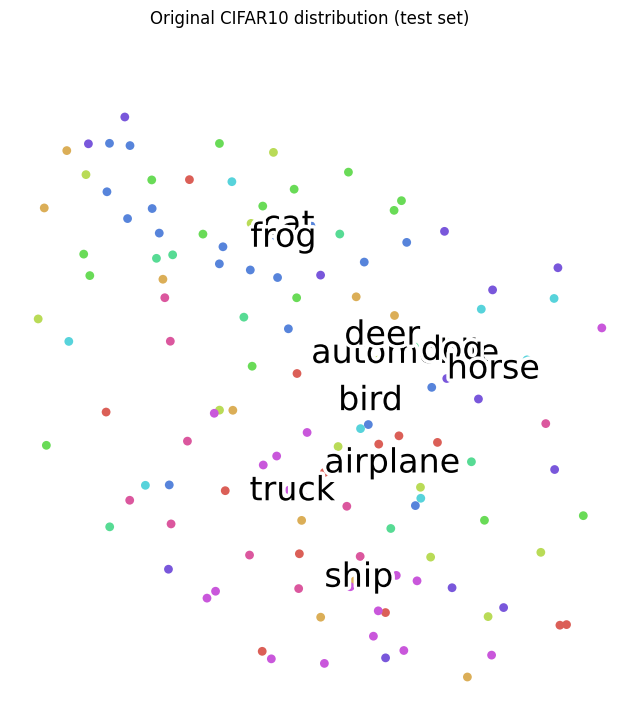

In [114]:
scatter(train_tsne_embeds, y_train, subtitle=f'Original CIFAR10 distribution (train set)', idx2name=idx2name)
scatter(test_tsne_embeds, y_test, subtitle=f'Original CIFAR10 distribution (test set)', idx2name=idx2name)

In [56]:

device = torch.device("cpu")


In [44]:
from SupContrast.networks.resnet_big import SupConResNet, LinearClassifier

In [45]:

model = SupConResNet(name="resnet18",head="linear",feat_dim=512)
classifier = LinearClassifier(name="resnet18", num_classes=10)

In [57]:
ckpt = torch.load("./SupContrast/last.pth", map_location='cpu')
model_state_dict = ckpt['model']

new_state_dict = {}
for k, v in model_state_dict.items():
    k = k.replace("module.", "")
    new_state_dict[k] = v
model_state_dict = new_state_dict


classifier_state_dict = torch.load('./SupContrast/classifier.torch',map_location='cpu')

model.load_state_dict(model_state_dict)
classifier.load_state_dict(classifier_state_dict)

<All keys matched successfully>

plot/SupContrast distribution (train set)
plot/SupContrast distribution (test set)


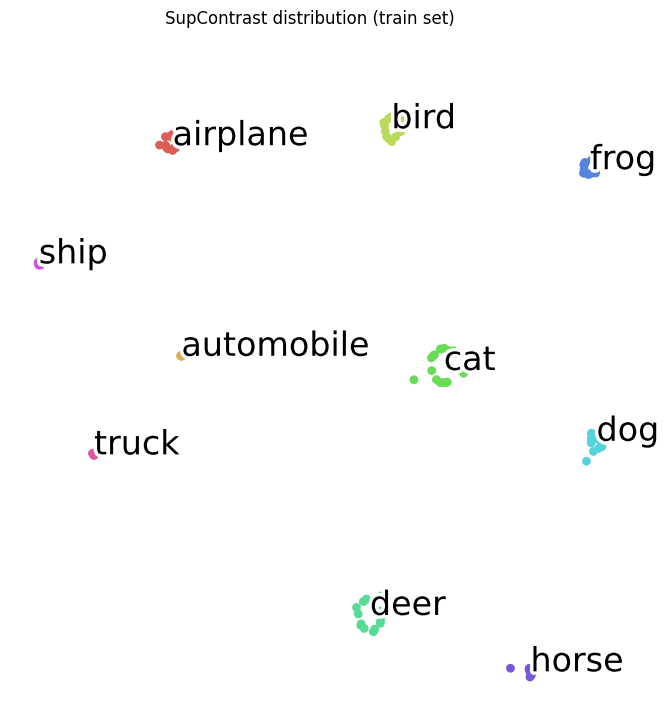

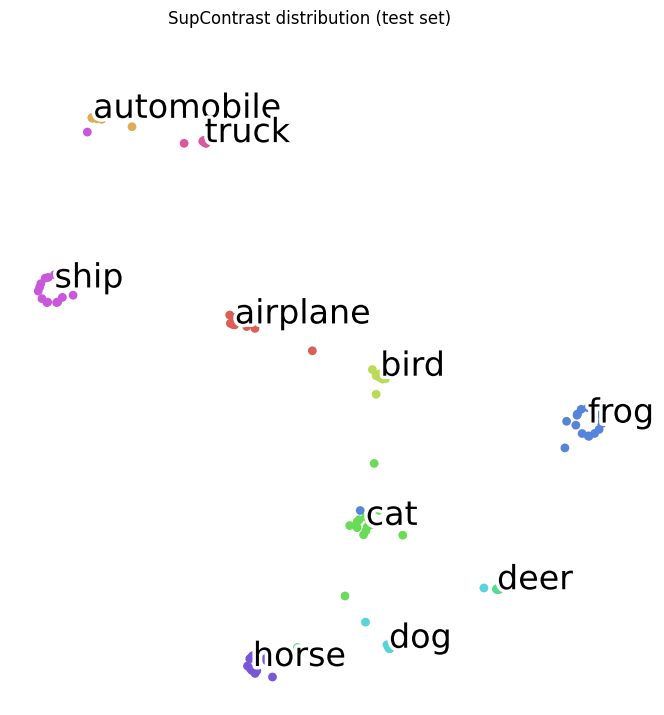

In [117]:
train_outputs = model(torch.tensor(x_train).reshape(128,3,32,32).to(device))
test_outputs = model(torch.tensor(x_test).reshape(128,3,32,32).to(device))
train_tsne_embeds = tsne.fit_transform(train_outputs.cpu().detach().numpy())
test_tsne_embeds = tsne.fit_transform(test_outputs.cpu().detach().numpy())

scatter(train_tsne_embeds, y_train, subtitle=f'SupContrast distribution (train set)', idx2name=idx2name)
scatter(test_tsne_embeds, y_test, subtitle=f'SupContrast distribution (test set)', idx2name=idx2name)

In [3]:
train_features, train_labels = torch.load('./SupContrast/features/train_SupContrast_fe.torch'), torch.load('./SupContrast/features/train_SupContrast_labels.torch')
valid_features, valid_labels = torch.load('./SupContrast/features/valid_SupContrast_fe.torch'), torch.load('./SupContrast/features/valid_SupContrast_labels.torch')

In [37]:
from sklearn.neighbors import KNeighborsClassifier

for n in [2,5,10,20,30,40,50,60,70,80,90,100,150,300]:
    neigh_full = KNeighborsClassifier(n_neighbors=n)

    neigh_full.fit(train_features.numpy(), train_labels.numpy())
    knn_512_res = neigh_full.predict_proba(valid_features.numpy())
    knn_512 = (knn_512_res.argmax(1) == valid_labels.numpy()).sum() / len(valid_labels)
    print(knn_512,n)


0.9383 2
0.9419 5
0.9421 10
0.9415 20
0.9412 30
0.9411 40
0.9415 50
0.9412 60
0.9405 70
0.9404 80
0.9402 90
0.9404 100
0.9405 150
0.9372 300


In [38]:
n_neighbors = 20

neigh_full = KNeighborsClassifier(n_neighbors=40)

neigh_full.fit(train_features.numpy(), train_labels.numpy())
knn_512_res = neigh_full.predict_proba(valid_features.numpy())

In [42]:
trs = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95]
knn_full_res = []
res_tr_dict_full = dict()
num_of_passed_dict_full = dict()
for tr in trs:
        idxs = knn_512_res.max(1)> tr
        num_of_passed_dict_full[tr] = (idxs.sum() / len(valid_labels))
        res_tr_dict_full[tr] = ((knn_512_res[idxs].argmax(1) == valid_labels.numpy()[idxs]).sum() / len(valid_labels.numpy()[idxs]))


In [59]:
classifier.eval()
with torch.no_grad():
    classifier_results_valid = classifier(valid_features.to(device))

In [60]:
fc_results = (classifier_results_valid.softmax(dim=1).max(dim=1)[1].cpu() == valid_labels).sum() / len(valid_labels)

In [61]:
from sklearn.random_projection import SparseRandomProjection
rng = np.random.RandomState(42)
trs = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95]
res = []
res_tr_dict = {}
num_of_passed_dict = {}
for comp in [256,128,64,32,16,4,2]:
    sp = SparseRandomProjection(n_components = comp,random_state=rng)
    X = sp.fit_transform(train_features.numpy())

    neigh = KNeighborsClassifier(n_neighbors=n_neighbors)
    
    neigh.fit(X, train_labels.numpy())
    TEST = sp.transform(valid_features.numpy())
    valid_res = neigh.predict_proba(TEST)
    res.append((valid_res.argmax(1) == valid_labels.numpy()).sum() / len(valid_labels))
    res_tr_dict[comp] = dict()
    num_of_passed_dict[comp] = dict()
    for tr in trs:
        idxs = valid_res.max(1)> tr
        num_of_passed_dict[comp][tr] = (idxs.sum() / len(valid_labels))
        res_tr_dict[comp][tr] = ((valid_res[idxs].argmax(1) == valid_labels.numpy()[idxs]).sum() / len(valid_labels.numpy()[idxs]))


In [62]:
s_c = classifier_results_valid.softmax(dim=1)
cls_results = dict()
cls_per = dict()
for tr in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95]:
    idxs = s_c.max(dim=1)[0] > tr
    cls_results[tr] = (s_c[idxs].max(dim=1)[1].cpu() == valid_labels[idxs.cpu()]).sum() / len(valid_labels[idxs.cpu()])
    cls_per[tr] = (sum(idxs) / len(valid_labels)).item()

In [63]:
from sklearn.decomposition import PCA
rng = np.random.RandomState(42)
trs = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95]
res_pca = []
res_tr_dict_pca = {}
num_of_passed_dict_pca = {}
for comp in [256,128,64,32,16,4,2]:
    sp = PCA(n_components = comp,random_state=rng)
    X = sp.fit_transform(train_features.numpy())

    neigh = KNeighborsClassifier(n_neighbors=n_neighbors)
    
    neigh.fit(X, train_labels.numpy())
    TEST = sp.transform(valid_features.numpy())
    valid_res = neigh.predict_proba(TEST)
    res_pca.append((valid_res.argmax(1) == valid_labels.numpy()).sum() / len(valid_labels))
    res_tr_dict_pca[comp] = dict()
    num_of_passed_dict_pca[comp] = dict()
    for tr in trs:
        idxs = valid_res.max(1)> tr
        num_of_passed_dict_pca[comp][tr] = (idxs.sum() / len(valid_labels))
        res_tr_dict_pca[comp][tr] = ((valid_res[idxs].argmax(1) == valid_labels.numpy()[idxs]).sum() / len(valid_labels.numpy()[idxs]))


In [21]:
device = torch.device('mps')
#device = torch.device('cpu')

In [22]:
train_features, train_labels = torch.load('./SupContrast/features/train_SupContrast_fe.torch'), torch.load('./SupContrast/features/train_SupContrast_labels.torch')
valid_features, valid_labels = torch.load('./SupContrast/features/valid_SupContrast_fe.torch'), torch.load('./SupContrast/features/valid_SupContrast_labels.torch')

In [23]:
from torch import nn
from torch import optim
import math

In [24]:
class Autoencoder(nn.Module):
    def __init__(self, in_shape, enc_shape):
        super(Autoencoder, self).__init__()
        
        self.encode = nn.Sequential(
            nn.Linear(in_shape, 256),
        )
        depth = [2**i for i in range(int(math.log2(128)),int(math.log2(enc_shape))-1,-1)]
        last = 256
        for d in depth:
            self.encode.extend([
                nn.ReLU(True),
                nn.Dropout(0.2),
                nn.Linear(last, d)
            ])
            last = d
        
        self.decode = nn.Sequential(
            nn.BatchNorm1d(enc_shape)
        )
        depth = [2**i for i in range(int(math.log2(256)),int(math.log2(enc_shape))-1,-1)]
        depth.reverse()
        for d in depth[1:]:
            self.decode.extend([
                nn.Linear(last, d),
                nn.ReLU(True),
                nn.Dropout(0.2),
            ])
            last = d
        
        self.decode.append(nn.Linear(last, in_shape))
        
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x
    

In [25]:
def train(model, error, optimizer, n_epochs, x):
    model.train()
    for epoch in range(1, n_epochs + 1):
        optimizer.zero_grad()
        output = model(x)
        loss = error(output, x)
        loss.backward()
        optimizer.step()
        
        if epoch % int(0.1*n_epochs) == 0:
            print(f'epoch {epoch} \t Loss: {loss.item():.4g}')

In [26]:
models_encoder = dict()
train_data = train_features.clone().to(device)
for dim in [256,128,64,32,16,4,2]:
    encoder = Autoencoder(in_shape=512, enc_shape=dim).to(device)
    #print(encoder)
    error = nn.MSELoss()

    optimizer = optim.Adam(encoder.parameters())

    train(encoder, error, optimizer, 5000, train_data )
    
    models_encoder[dim] = encoder.to("cpu").encode.state_dict()
    del encoder
    del optimizer

epoch 500 	 Loss: 0.0009654
epoch 1000 	 Loss: 0.0005939
epoch 1500 	 Loss: 0.0004261
epoch 2000 	 Loss: 0.0003346
epoch 2500 	 Loss: 0.0002745
epoch 3000 	 Loss: 0.0002502
epoch 3500 	 Loss: 0.0002156
epoch 4000 	 Loss: 0.0001924
epoch 4500 	 Loss: 0.0002007
epoch 5000 	 Loss: 0.0001783
epoch 500 	 Loss: 0.001994
epoch 1000 	 Loss: 0.001587
epoch 1500 	 Loss: 0.001412
epoch 2000 	 Loss: 0.001342
epoch 2500 	 Loss: 0.001305
epoch 3000 	 Loss: 0.001301
epoch 3500 	 Loss: 0.001273
epoch 4000 	 Loss: 0.001251
epoch 4500 	 Loss: 0.001233
epoch 5000 	 Loss: 0.00123
epoch 500 	 Loss: 0.002129
epoch 1000 	 Loss: 0.001793
epoch 1500 	 Loss: 0.001642
epoch 2000 	 Loss: 0.001564
epoch 2500 	 Loss: 0.001519
epoch 3000 	 Loss: 0.001495
epoch 3500 	 Loss: 0.001481
epoch 4000 	 Loss: 0.00146
epoch 4500 	 Loss: 0.001447
epoch 5000 	 Loss: 0.001442
epoch 500 	 Loss: 0.002281
epoch 1000 	 Loss: 0.001991
epoch 1500 	 Loss: 0.001881
epoch 2000 	 Loss: 0.001837
epoch 2500 	 Loss: 0.001804
epoch 3000 	 Los

In [99]:
torch.save(models_encoder,'./autoencoders_supcontrast.pickle')

In [35]:
autoencoder_featres_train = dict()
autoencoder_featres_valid = dict()
for dim in [256,128,64,32,16,4,2]:
    encoder = Autoencoder(in_shape=512, enc_shape=dim).encode
    encoder.load_state_dict(models_encoder[dim])
    encoder.eval()
    with torch.no_grad():
        autoencoder_featres_train[dim] = encoder(train_data.cpu()).cpu()
        autoencoder_featres_valid[dim] = encoder(valid_features.clone()).cpu()

In [64]:
trs = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95]
res_autoencoder = []
res_tr_dict_autoencoder = {}
num_of_passed_dict_autoencoder = {}
for comp in [256,128,64,32,16,4,2]:

    neigh = KNeighborsClassifier(n_neighbors=n_neighbors)
    
    neigh.fit(autoencoder_featres_train[comp].numpy(), train_labels.numpy())
    TEST = autoencoder_featres_valid[comp].numpy()
    valid_res = neigh.predict_proba(TEST)
    res_autoencoder.append((valid_res.argmax(1) == valid_labels.numpy()).sum() / len(valid_labels))
    res_tr_dict_autoencoder[comp] = dict()
    num_of_passed_dict_autoencoder[comp] = dict()
    for tr in trs:
        idxs = valid_res.max(1)> tr
        num_of_passed_dict_autoencoder[comp][tr] = (idxs.sum() / len(valid_labels))
        res_tr_dict_autoencoder[comp][tr] = ((valid_res[idxs].argmax(1) == valid_labels.numpy()[idxs]).sum() / len(valid_labels.numpy()[idxs]))


In [106]:
root = './plot'

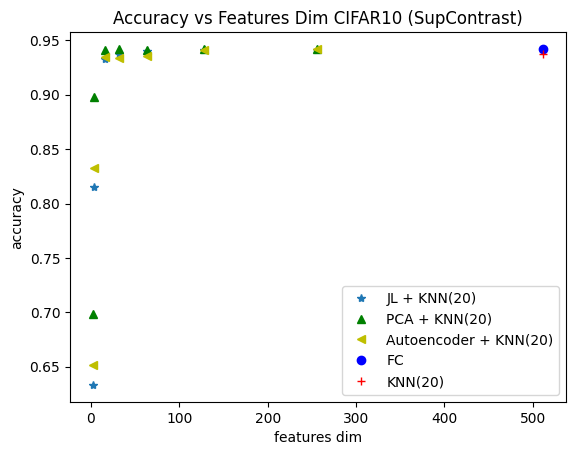

<Figure size 640x480 with 0 Axes>

In [107]:
plt.plot([256,128,64,32,16,4,2],res,'*',label=f"JL + KNN({n_neighbors})")
plt.plot([256,128,64,32,16,4,2],res_pca,'g^',label=f"PCA + KNN({n_neighbors})")
plt.plot([256,128,64,32,16,4,2],res_autoencoder,'y<',label=f"Autoencoder + KNN({n_neighbors})")
plt.plot([512,],fc_results,'bo',label="FC")
plt.plot([512,],[knn_512,],'r+',label=f"KNN({n_neighbors})")
plt.title("Accuracy vs Features Dim CIFAR10 (SupContrast)")
plt.xlabel("features dim")
plt.ylabel("accuracy")
plt.legend()
plt.show()
plt.savefig(os.path.join(root, "Accuracy vs Features Dim CIFAR10 (SupContrast) dots"))

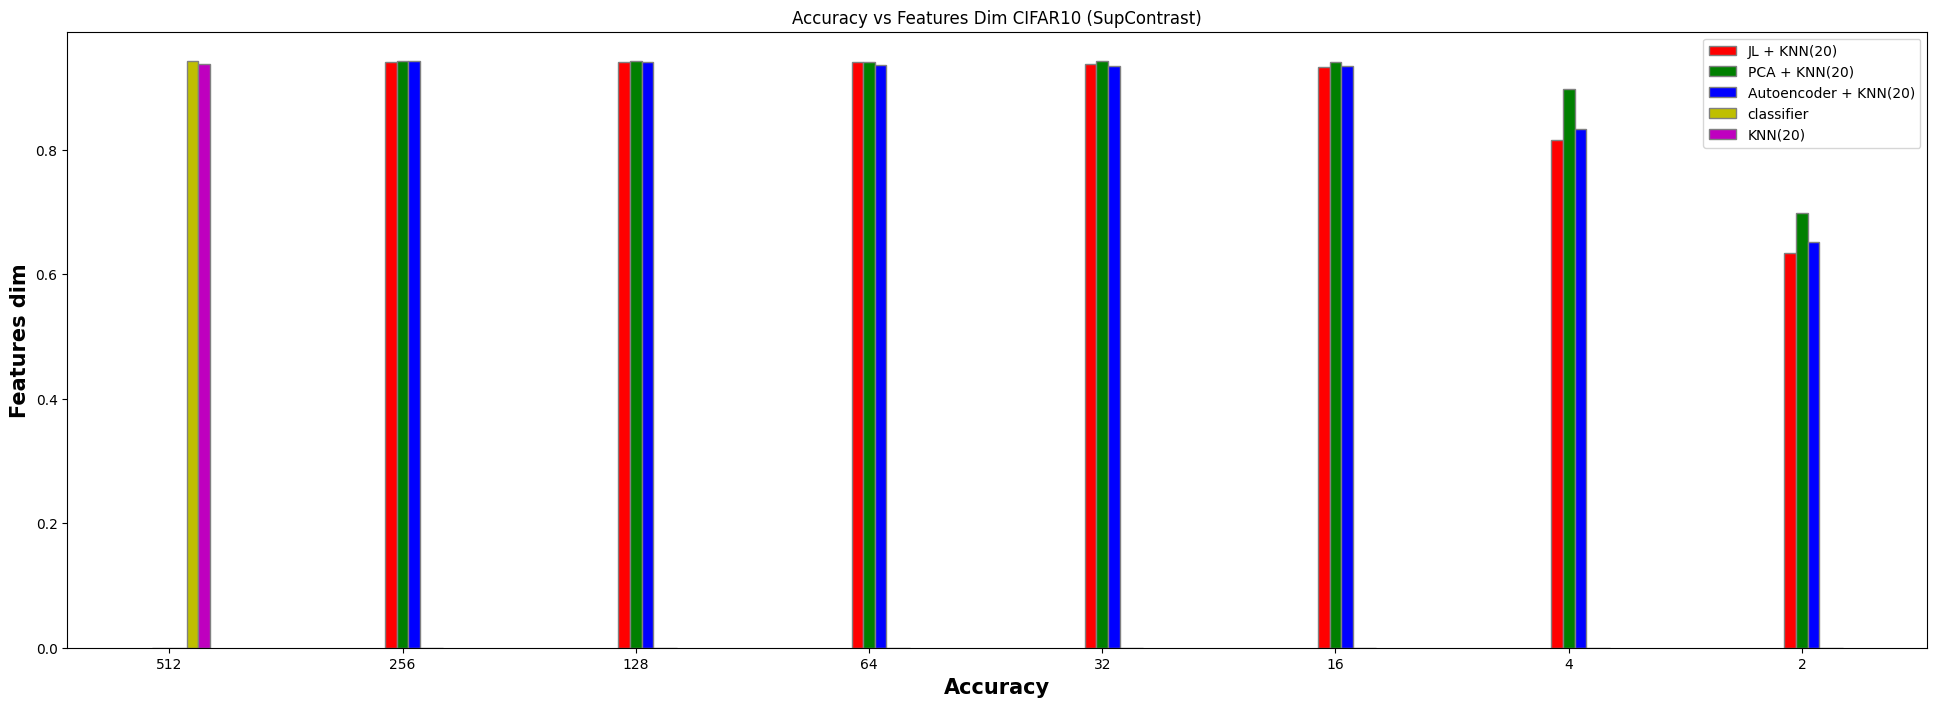

In [119]:
# set width of bar
barWidth = 0.05
fig = plt.subplots(figsize =(24, 8))

 
# Set position of bar on X axis
br1 = np.arange(len(res)+1)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]

# Make the plot
plt.bar(br1, [0,]+res, color ='r', width = barWidth,
        edgecolor ='grey', label=f"JL + KNN({n_neighbors})")
plt.bar(br2, [0,]+res_pca, color ='g', width = barWidth,
        edgecolor ='grey', label =f"PCA + KNN({n_neighbors})")
plt.bar(br3, [0,]+res_autoencoder, color ='b', width = barWidth,
        edgecolor ='grey', label =f"Autoencoder + KNN({n_neighbors})")
plt.bar(br4, [fc_results.tolist(),]+[0,]*len(res), color ='y', width = barWidth,
        edgecolor ='grey', label =f"classifier")
plt.bar(br5, [knn_512,]+[0,]*len(res), color ='m', width = barWidth,
        edgecolor ='grey', label =f"KNN({n_neighbors})")
 
# Adding Xticks
plt.title("Accuracy vs Features Dim CIFAR10 (SupContrast)")
plt.xlabel('Accuracy', fontweight ='bold', fontsize = 15)
plt.ylabel('Features dim', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len([512,256,128,64,32,16,4,2]))],
        [512,256,128,64,32,16,4,2])
 
plt.legend()
plt.savefig(os.path.join(root, "Accuracy vs Features Dim CIFAR10 (SupContrast) bars"))
plt.show()


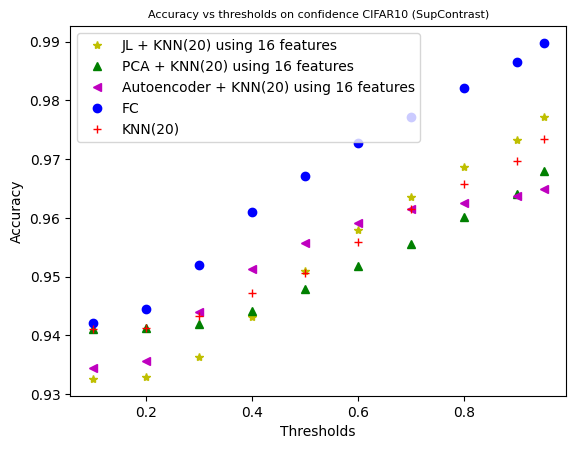

In [123]:
plt.plot(trs,res_tr_dict[16].values(),'y*',label=f"JL + KNN({n_neighbors}) using 16 features ")
plt.plot(trs,res_tr_dict_pca[16].values(),'g^',label=f"PCA + KNN({n_neighbors}) using 16 features")
plt.plot(trs,res_tr_dict_autoencoder[16].values(),'m<',label=f"Autoencoder + KNN({n_neighbors}) using 16 features")
plt.plot(trs,list(cls_results.values()),'bo',label="FC")
plt.plot(trs,list(res_tr_dict_full.values()),'r+',label=f"KNN({n_neighbors})")
plt.title("Accuracy vs thresholds on confidence CIFAR10 (SupContrast)",fontsize = 8)
plt.xlabel("Thresholds")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(os.path.join(root, "Accuracy vs thresholds on confidence CIFAR10 (SupContrast)"))
plt.show()


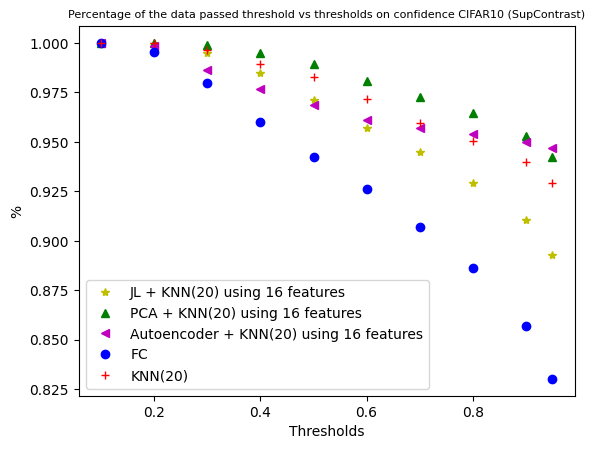

In [122]:
plt.plot(trs,num_of_passed_dict[16].values(),'y*',label=f"JL + KNN({n_neighbors}) using 16 features ")
plt.plot(trs,num_of_passed_dict_pca[16].values(),'g^',label=f"PCA + KNN({n_neighbors}) using 16 features")
plt.plot(trs,num_of_passed_dict_autoencoder[16].values(),'m<',label=f"Autoencoder + KNN({n_neighbors}) using 16 features")
plt.plot(trs,cls_per.values(),'bo',label="FC")
plt.plot(trs,num_of_passed_dict_full.values(),'r+',label=f"KNN({n_neighbors})")
plt.title("Percentage of the data passed threshold vs thresholds on confidence CIFAR10 (SupContrast)",fontsize = 8)
plt.xlabel("Thresholds")
plt.ylabel("%")
plt.legend()
plt.savefig(os.path.join(root, "Percentage of the data passed threshold vs thresholds on confidence CIFAR10 (SupContrast)"))
plt.show()
